In [30]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

import statistics

import xgboost as xgb

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from scipy import stats

In [31]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

test_id = test_data['Id']
target = train_data.SalePrice
test_data_len = test_data.shape[0]

print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [32]:
#?train_data.drop

In [33]:
all_data = pd.concat([train_data, test_data], axis="index", sort=False)
all_data = all_data.drop(['Id', 'SalePrice'], axis="columns")

all_data.shape

(2919, 79)

In [34]:
missing_vals = all_data.isnull().sum().sort_values()
n_missing_vals = (all_data.isnull().sum().sort_values()).sum()

print(n_missing_vals)

13965


In [35]:
missing_perc = (all_data.isnull().sum() / all_data.isnull().count()).sort_values()
missing_perc.head()

MSSubClass    0.0
Foundation    0.0
Heating       0.0
CentralAir    0.0
1stFlrSF      0.0
dtype: float64

In [36]:
missin_data = pd.concat([missing_vals, missing_perc], axis='columns', keys=["n", "%"])
missin_data.tail()

,n,%
FireplaceQu,1420,0.486468
Fence,2348,0.804385
Alley,2721,0.932169
MiscFeature,2814,0.964029
PoolQC,2909,0.996574


In [37]:
all_data = all_data.drop(missin_data[missin_data["%"] > 0.05].index, axis="columns")

In [38]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 68 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotArea        2919 non-null   int64  
 3   Street         2919 non-null   object 
 4   LotShape       2919 non-null   object 
 5   LandContour    2919 non-null   object 
 6   Utilities      2917 non-null   object 
 7   LotConfig      2919 non-null   object 
 8   LandSlope      2919 non-null   object 
 9   Neighborhood   2919 non-null   object 
 10  Condition1     2919 non-null   object 
 11  Condition2     2919 non-null   object 
 12  BldgType       2919 non-null   object 
 13  HouseStyle     2919 non-null   object 
 14  OverallQual    2919 non-null   int64  
 15  OverallCond    2919 non-null   int64  
 16  YearBuilt      2919 non-null   int64  
 17  YearRemodAdd   2919 non-null   int64  
 18  RoofStyl

<AxesSubplot:>

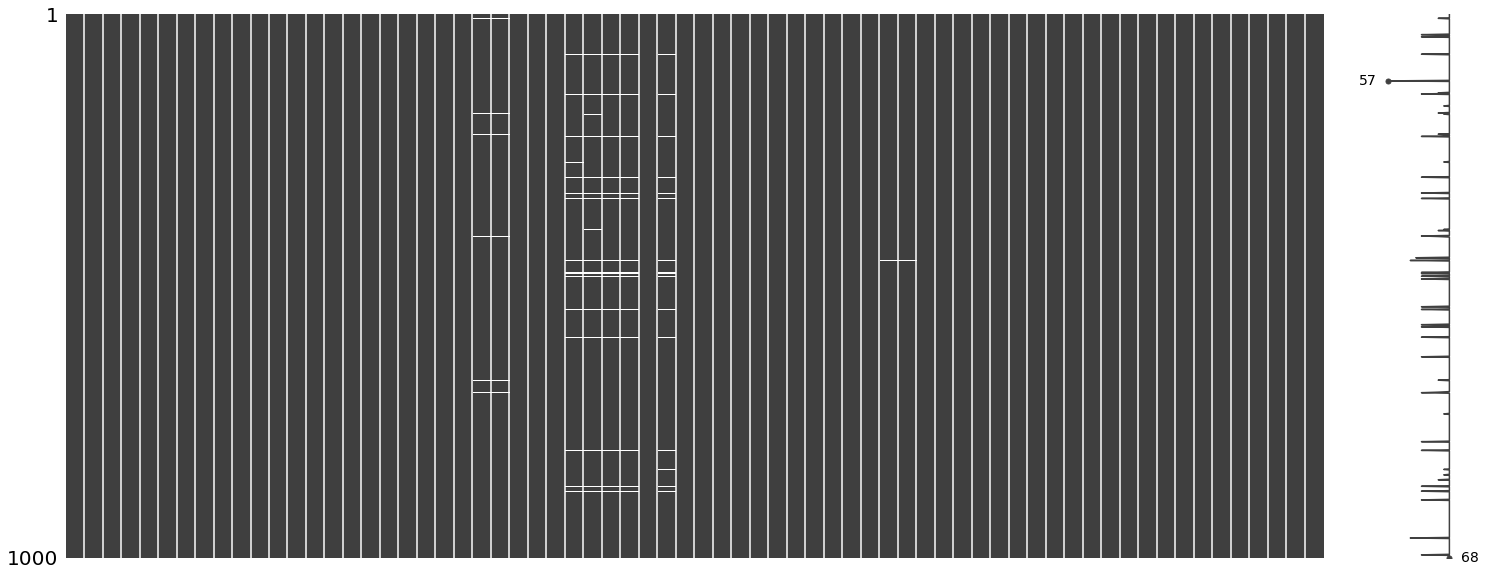

In [39]:
msno.matrix(all_data.sample(1000))

In [40]:
np.unique(all_data.dtypes)

array([dtype('int64'), dtype('float64'), dtype('O')], dtype=object)

In [41]:
def segment_features_colms(dataset):
    cat_feat = list(filter(lambda x: dataset[x].dtype == "O", dataset.columns))
    num_feat = dataset.drop(cat_feat, axis="columns").columns
    return list(num_feat), list(cat_feat)

In [42]:
num_cols, cat_cols = segment_features_colms(all_data)
le = LabelEncoder()

all_data[cat_cols] = all_data[cat_cols].apply(lambda col: le.fit_transform(col.astype(str)), axis=0, result_type='expand')

In [43]:
for col in cat_cols:
    all_data[col] = le.fit_transform(all_data[col])

In [44]:
np.unique(all_data.dtypes)

array([dtype('int64'), dtype('float64')], dtype=object)

In [45]:
#all_data[cat_cols].info()  # categorical cols are full

In [46]:
all_data[num_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 34 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   LotArea        2919 non-null   int64  
 2   OverallQual    2919 non-null   int64  
 3   OverallCond    2919 non-null   int64  
 4   YearBuilt      2919 non-null   int64  
 5   YearRemodAdd   2919 non-null   int64  
 6   MasVnrArea     2896 non-null   float64
 7   BsmtFinSF1     2918 non-null   float64
 8   BsmtFinSF2     2918 non-null   float64
 9   BsmtUnfSF      2918 non-null   float64
 10  TotalBsmtSF    2918 non-null   float64
 11  1stFlrSF       2919 non-null   int64  
 12  2ndFlrSF       2919 non-null   int64  
 13  LowQualFinSF   2919 non-null   int64  
 14  GrLivArea      2919 non-null   int64  
 15  BsmtFullBath   2917 non-null   float64
 16  BsmtHalfBath   2917 non-null   float64
 17  FullBath       2919 non-null   int64  
 18  HalfBath

In [47]:
imputer = SimpleImputer(strategy="median")

cols = all_data.columns
all_data = pd.DataFrame(imputer.fit_transform(all_data))

all_data.columns = cols

#all_data.info()  # full of values

In [48]:
X_train = np.array(all_data[:test_data_len + 1])
X_test = np.array(all_data[test_data_len + 1:])

X_train, X_valid, y_train, y_valid = train_test_split(X_train, target, train_size=0.8, test_size=0.2, random_state=1)

## Random forest regressor

In [49]:
print(len(X_valid))

292


In [50]:
model = RandomForestRegressor(n_estimators=500, random_state=1)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, random_state=1)

In [51]:
predict_vals_randomForest = model.predict(X_valid)

In [52]:
def stats(valid, predict):
    mae = mean_absolute_error(valid, predict)
    mse = mean_squared_error(valid, predict)
    rmse = np.sqrt(mse)
    cv = rmse / statistics.mean(valid)
    
    return mae, rmse, cv

In [53]:
mae_randomFores, rmse_randomFores, cv_randomFores = stats(y_valid, predict_vals_randomForest)

In [54]:
print(f"MAE={mae_randomFores}, RMSE={rmse_randomFores}, CV={cv_randomFores}")

MAE=16218.980554794523, RMSE=26661.366309328714, CV=0.1516810033839054


## XGBRegressor

In [55]:
model_boost = xgb.XGBRegressor(n_estimators=500,max_depth=2,objective='reg:linear')
model_boost.fit(X_train, y_train, verbose=True)

[00:29:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=8, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [56]:
predict_vals_XGB = model_boost.predict(X_valid)

In [57]:
mae_XGB, rmse_XGB, cv_XGB = stats(y_valid, predict_vals_XGB)

print(f"MAE={mae_XGB}, RMSE={rmse_XGB}, CV={cv_XGB}")

MAE=15104.989538741438, RMSE=22864.389803816866, CV=0.13007936453692565


In [58]:
preds =  model_boost.predict(X_test)

sub = pd.DataFrame()
sub['Id'] = test_id
sub['SalePrice'] = preds
sub.to_csv('submission.csv',index=False)
print(sub)

        Id      SalePrice
0     1461  122671.640625
1     1462  172823.562500
2     1463  191916.156250
3     1464  199003.906250
4     1465  177902.171875
...    ...            ...
1454  2915   76412.367188
1455  2916   85275.015625
1456  2917  169122.000000
1457  2918  115141.734375
1458  2919  198408.562500

[1459 rows x 2 columns]


C:\Users\Vlad\AppData\Roaming\Python\Python38\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
